In [ ]:
# Install required dependencies
!apt-get install -y libta-lib0 libta-lib-dev

# Then install the Python wrapper
!pip install ta-lib


In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
!pip install conda-package-handling
!wget https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
!cph x ta-lib-0.5.1-py311h9ecbd09_0.conda
!mv ./ta-lib-0.5.1-py311h9ecbd09_0/lib/python3.11/site-packages/talib /usr/local/lib/python3.11/dist-packages/
import talib

In [ ]:
!pip install talib

In [ ]:
!pip install praw pandas nltk feedparser

In [ ]:
import praw
import pandas as pd
import numpy as np
import yfinance as yf
import talib
import requests
from bs4 import BeautifulSoup
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import download
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime, timedelta
from nltk.sentiment.vader import SentimentIntensityAnalyzer


In [ ]:
download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:

reddit = praw.Reddit(
    client_id='jeRux7eRayMDlKw2LRKAmQ',
    client_secret='rsbKqSjjL8aJHyx-sEHAkNnaqlJssA',
    user_agent='Project by /u/Next-Bell-4385'
)

sia = SentimentIntensityAnalyzer()
subreddit = reddit.subreddit("stocks")
keyword = "Tesla"

two_years_ago = datetime.today() - timedelta(days=2*365)

posts = []
for post in subreddit.search(keyword, limit=1000):
    post_date = pd.to_datetime(post.created_utc, unit='s')
    if post_date >= two_years_ago:
        posts.append({
            'title': post.title,
            'score': post.score,
            'url': post.url,
            'date': post_date.date(),
            'source': 'Reddit'
        })

df_posts = pd.DataFrame(posts)
df_posts['sentiment_score'] = df_posts['title'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Average daily sentiment from Reddit
reddit_daily = df_posts.groupby('date')['sentiment_score'].mean().reset_index()
print(reddit_daily.head())

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



         date  sentiment_score
0  2023-07-27          -0.4939
1  2023-08-04          -0.3182
2  2023-08-29           0.0000
3  2023-10-06          -0.2960
4  2023-12-29           0.4019


In [ ]:
print(reddit_daily.shape)

(125, 2)


In [ ]:
import feedparser
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Tesla-specific RSS feed from Google News
rss_url = "https://news.google.com/rss/search?q=Tesla&hl=en-IN&gl=IN&ceid=IN:en"

# Parse RSS feed
feed = feedparser.parse(rss_url)

titles = []
dates = []

for entry in feed.entries:
    title = entry.title
    date = pd.to_datetime(entry.published) if hasattr(entry, 'published') else None
    titles.append(title)
    dates.append(date)

# Create DataFrame
df_news = pd.DataFrame({'title': titles, 'date': dates})

# Clean date and drop missing ones
df_news = df_news.dropna(subset=['date'])
df_news['date'] = pd.to_datetime(df_news['date'], utc=True).dt.date  # ✅ Fix: Convert to UTC, then extract date

# Calculate sentiment
df_news['sentiment_score'] = df_news['title'].apply(lambda x: sia.polarity_scores(x)['compound'])
df_news['source'] = 'News'

# Daily average sentiment
news_daily = df_news.groupby('date')['sentiment_score'].mean().reset_index()

# Preview
print(news_daily.head())


         date  sentiment_score
0  2025-06-06           0.0000
1  2025-06-14           0.0000
2  2025-06-16           0.0000
3  2025-06-20           0.0000
4  2025-06-28          -0.3089


In [ ]:
print(df_news.head())

                                               title        date  \
0  Elon Musk (And Tesla) Became Much Less Popular...  2025-07-04   
1  Tesla Is in Disarray. Musk Has Already Moved B...  2025-07-03   
2  Tesla CEO Elon Musk: ‘It’s time to retire…’ - ...  2025-07-05   
3  ‘Elon has finally woken up’: Musk battles to s...  2025-07-04   
4  Tesla UK sales up 14% in June this year - fina...  2025-07-04   

   sentiment_score source  
0           0.3626   News  
1           0.4939   News  
2           0.0000   News  
3           0.1531   News  
4           0.0000   News  


In [ ]:
df_sentiment_daily = pd.concat([reddit_daily, news_daily], ignore_index=True)
df_sentiment_daily = df_sentiment_daily.groupby('date')['sentiment_score'].mean().reset_index()
df_sentiment_daily = df_sentiment_daily.sort_values('date').reset_index(drop=True)


In [ ]:
print(df_sentiment_daily.shape)

(132, 2)


In [ ]:
YEARS_TO_KEEP = 2
start_date = (datetime.today() - timedelta(days=YEARS_TO_KEEP*365)).strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')

stock_data = yf.download('TSLA', start=start_date, end=end_date, auto_adjust=False)
stock_data.dropna(inplace=True)
stock_data.reset_index(inplace=True)
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date

close_prices = np.asarray(stock_data['Close']).astype(float).flatten()

[*********************100%***********************]  1 of 1 completed


In [ ]:
stock_data['SMA_50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['EMA_50'] = stock_data['Close'].ewm(span=50, adjust=False).mean()
stock_data['RSI'] = talib.RSI(close_prices, timeperiod=14)
stock_data['MACD'], stock_data['MACD_Signal'], _ = talib.MACD(close_prices)
stock_data['Upper_Band'], stock_data['Middle_Band'], stock_data['Lower_Band'] = talib.BBANDS(close_prices, timeperiod=20)

stock_data['Price Change'] = stock_data['Close'].pct_change()
stock_data['Stock Movement'] = stock_data['Price Change'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
from datetime import timedelta

aligned_data = []

for date in stock_data['Date']:
    # First, try exact match
    sentiment_row = df_sentiment_daily[df_sentiment_daily['date'] == date]

    if not sentiment_row.empty:
        sentiment_score = sentiment_row['sentiment_score'].values[0]
    else:
        # If no exact match, look backward up to 6 days (previous week)
        past_week_start = date - timedelta(days=6)
        past_week_sentiments = df_sentiment_daily[
            (df_sentiment_daily['date'] >= past_week_start) &
            (df_sentiment_daily['date'] < date)  # strictly before the stock date
        ]
        if not past_week_sentiments.empty:
            # Pick closest previous date sentiment (max date less than 'date')
            closest_idx = (date - past_week_sentiments['date']).idxmin()
            sentiment_score = past_week_sentiments.loc[closest_idx, 'sentiment_score']
        else:
            # No sentiment data found in the previous week
            sentiment_score = None

    if sentiment_score is not None:
        row = stock_data[stock_data['Date'] == date].iloc[0]
        aligned_data.append([
            date,
            sentiment_score,
            row['Close'],
            row['Stock Movement'],
            row['SMA_50'],
            row['EMA_50'],
            row['RSI'],
            row['MACD'],
            row['MACD_Signal'],
            row['Upper_Band'],
            row['Lower_Band']
        ])

aligned_df = pd.DataFrame(aligned_data, columns=[
    'Date', 'sentiment_score', 'Close', 'Stock Movement',
    'SMA_50', 'EMA_50', 'RSI', 'MACD', 'MACD_Signal', 'Upper_Band', 'Lower_Band'
])

aligned_df.dropna(inplace=True)


In [ ]:
X = aligned_df[['sentiment_score', 'Close', 'SMA_50', 'EMA_50', 'RSI', 'MACD', 'MACD_Signal', 'Upper_Band', 'Lower_Band']].astype(float)
y = aligned_df['Stock Movement'].astype(int)


/tmp/ipython-input-16-730975896.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  X = aligned_df[['sentiment_score', 'Close', 'SMA_50', 'EMA_50', 'RSI', 'MACD', 'MACD_Signal', 'Upper_Band', 'Lower_Band']].astype(float)
/tmp/ipython-input-16-730975896.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  y = aligned_df['Stock Movement'].astype(int)


In [ ]:
print(aligned_df.head())

         Date  sentiment_score  \
0  2023-07-27          -0.4939   
1  2023-07-28          -0.4939   
2  2023-07-31          -0.4939   
3  2023-08-01          -0.4939   
4  2023-08-02          -0.4939   

                                               Close  \
0  Ticker
TSLA    255.710007
Name: 15, dtype: object   
1  Ticker
TSLA    266.440002
Name: 16, dtype: object   
2  Ticker
TSLA    267.429993
Name: 17, dtype: object   
3  Ticker
TSLA    261.070007
Name: 18, dtype: object   
4  Ticker
TSLA    254.110001
Name: 19, dtype: object   

                         Stock Movement  \
0  Ticker
    0
Name: 15, dtype: object   
1  Ticker
    1
Name: 16, dtype: object   
2  Ticker
    1
Name: 17, dtype: object   
3  Ticker
    0
Name: 18, dtype: object   
4  Ticker
    0
Name: 19, dtype: object   

                                   SMA_50  \
0  Ticker
    NaN
Name: 15, dtype: object   
1  Ticker
    NaN
Name: 16, dtype: object   
2  Ticker
    NaN
Name: 17, dtype: object   
3  Ticker
    NaN
N

In [ ]:
print(aligned_df.isnull().sum())

Date               0
sentiment_score    0
Close              0
Stock Movement     0
SMA_50             0
EMA_50             0
RSI                0
MACD               0
MACD_Signal        0
Upper_Band         0
Lower_Band         0
dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100],           # number of trees
    'max_depth': [5, 10, None],                # max tree depth
    'min_samples_split': [2, 5, 10],               # min samples to split node
    'min_samples_leaf': [1, 2, 4],                 # min samples in leaf node
    'max_features': ['auto', 'sqrt', 'log2'],      # number of features to consider at split
    'bootstrap': [True, False]                      # whether bootstrap samples are used
}

grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)


Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
324 fits failed out of a total of 972.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
324 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/util

Accuracy: 0.6071

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67        33
           1       0.52      0.52      0.52        23

    accuracy                           0.61        56
   macro avg       0.59      0.59      0.59        56
weighted avg       0.61      0.61      0.61        56



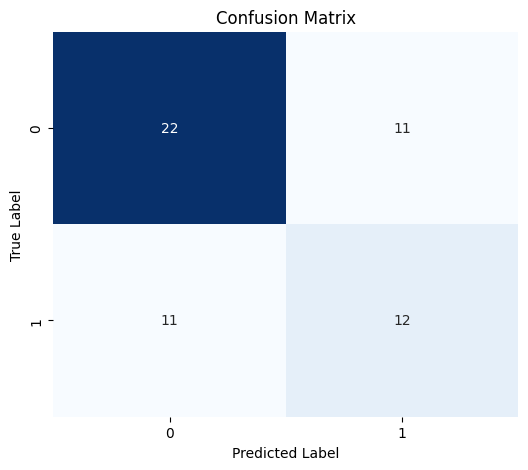

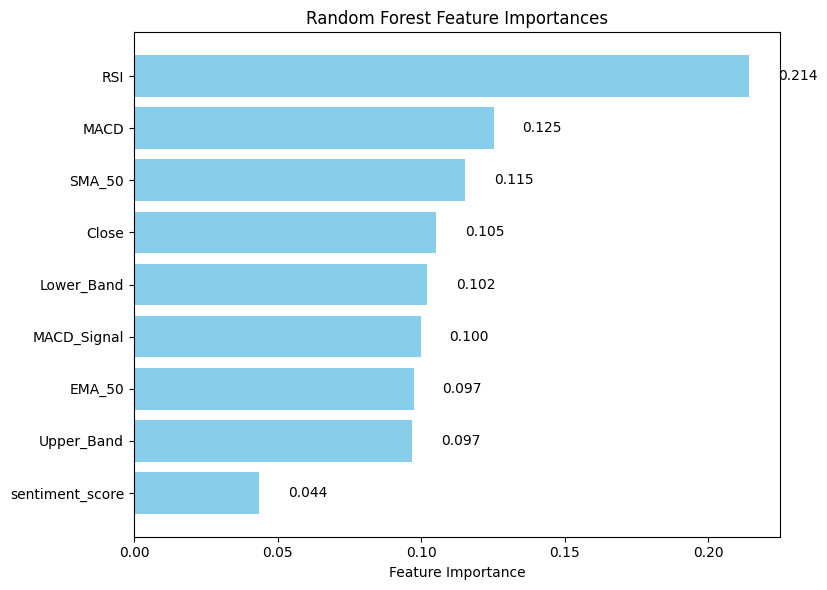

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict on test data
y_pred = best_model.predict(X_test_scaled)

# 1️⃣ Accuracy score
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}\n")

# 2️⃣ Classification report (better formatting)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# 3️⃣ Confusion matrix with heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title("Confusion Matrix")
plt.show()

# 4️⃣ Feature importance plot (sorted)
importances = best_model.feature_importances_
features = X.columns

# Sort features by importance
sorted_idx = importances.argsort()
plt.figure(figsize=(8,6))
plt.barh(features[sorted_idx], importances[sorted_idx], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()

# Annotate importance values on bars
for i, v in enumerate(importances[sorted_idx]):
    plt.text(v + 0.01, i, f"{v:.3f}", va='center')

plt.show()


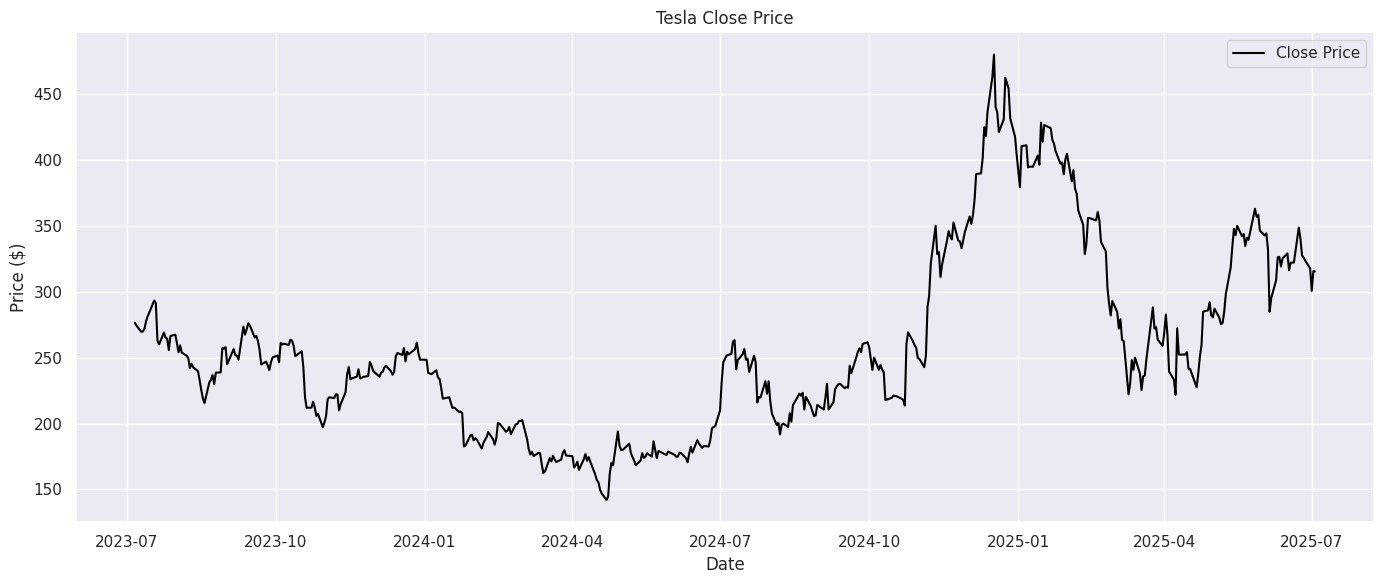

In [ ]:
sns.set(style="darkgrid")

# Plot 1: Close Price
plt.figure(figsize=(14, 6))
plt.plot(stock_data['Date'], stock_data['Close'], label='Close Price', color='black')
plt.title('Tesla Close Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.tight_layout()
plt.show()

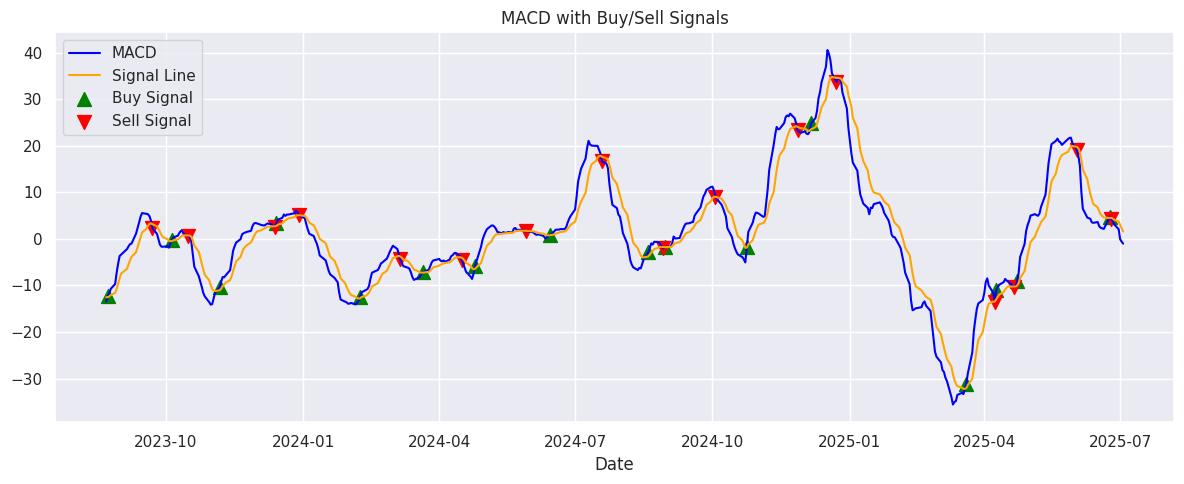

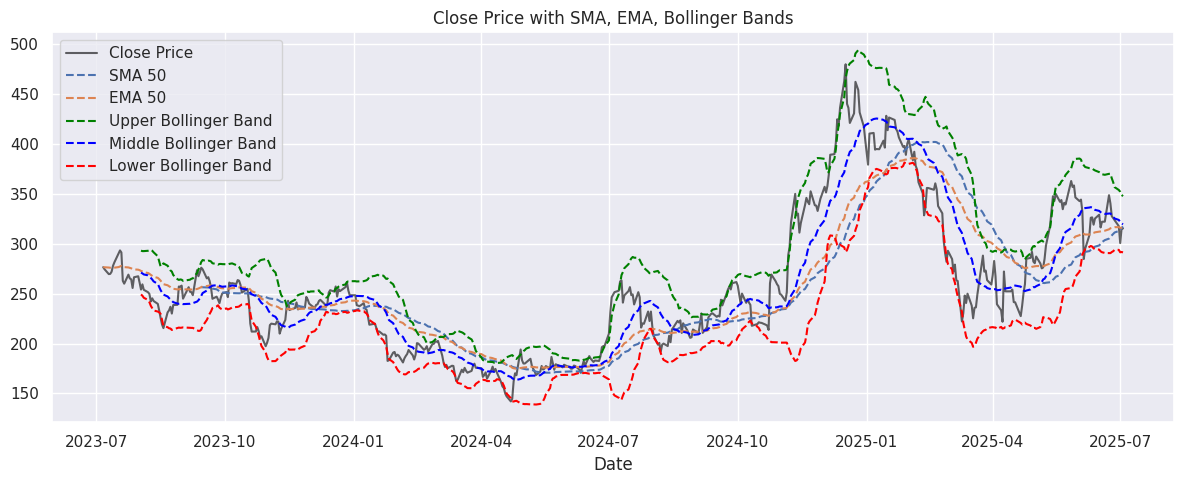

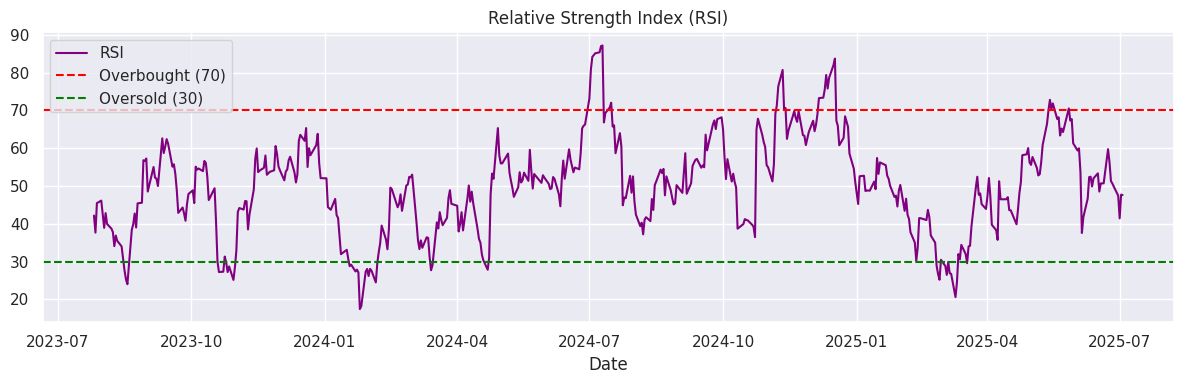

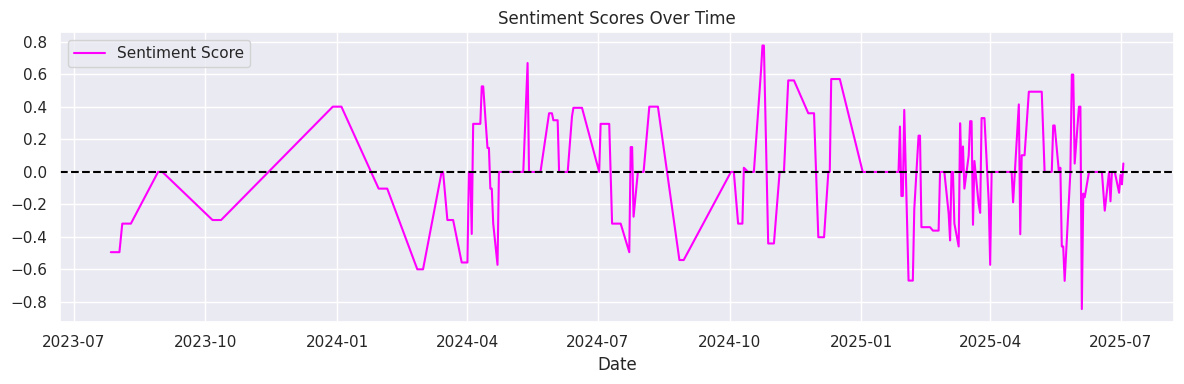

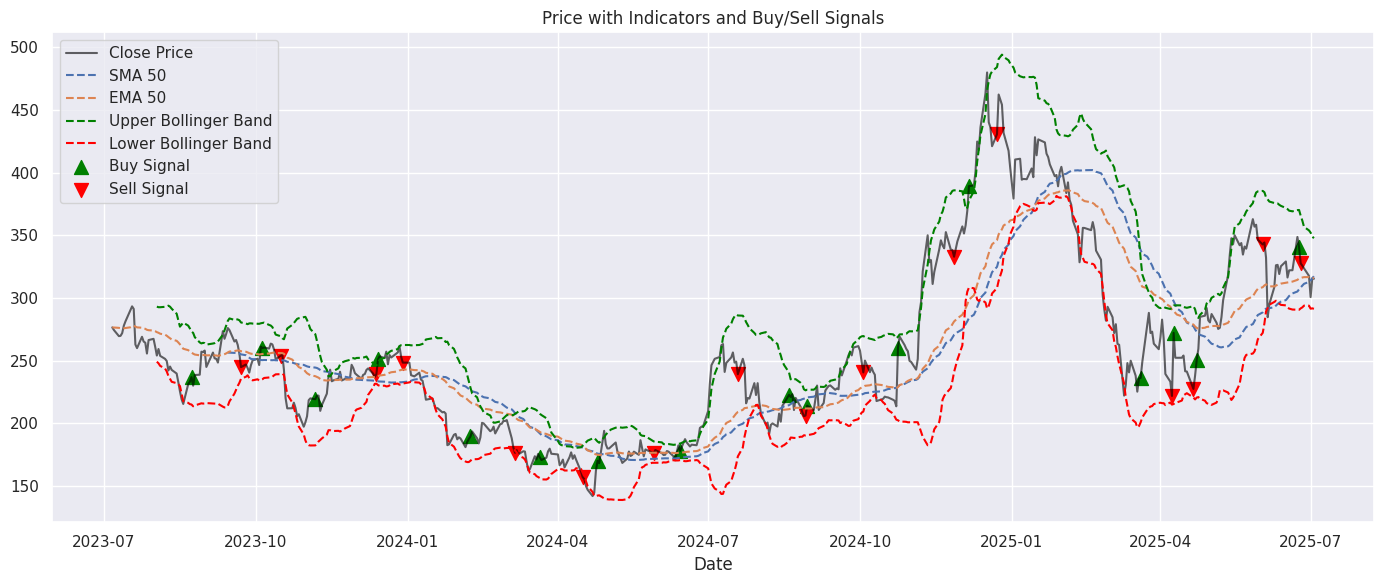

In [ ]:
import matplotlib.pyplot as plt

# --- Plot 1: MACD + Buy/Sell Signals ---
plt.figure(figsize=(12, 5))
plt.plot(stock_data['Date'], stock_data['MACD'], label='MACD', color='blue')
plt.plot(stock_data['Date'], stock_data['MACD_Signal'], label='Signal Line', color='orange')

macd = stock_data['MACD'].values
signal = stock_data['MACD_Signal'].values
dates = stock_data['Date']

buy_signals = []
sell_signals = []

for i in range(1, len(macd)):
    if macd[i] > signal[i] and macd[i-1] <= signal[i-1]:
        buy_signals.append((dates[i], macd[i]))
    elif macd[i] < signal[i] and macd[i-1] >= signal[i-1]:
        sell_signals.append((dates[i], macd[i]))

if buy_signals:
    buy_dates, buy_values = zip(*buy_signals)
    plt.scatter(buy_dates, buy_values, marker='^', color='green', label='Buy Signal', s=100)
if sell_signals:
    sell_dates, sell_values = zip(*sell_signals)
    plt.scatter(sell_dates, sell_values, marker='v', color='red', label='Sell Signal', s=100)

plt.title('MACD with Buy/Sell Signals')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.tight_layout()
plt.show()


# --- Plot 2: Bollinger Bands + SMA + EMA + Close Price ---
plt.figure(figsize=(12, 5))
plt.plot(stock_data['Date'], stock_data['Close'], label='Close Price', color='black', alpha=0.6)
plt.plot(stock_data['Date'], stock_data['SMA_50'], label='SMA 50', linestyle='--')
plt.plot(stock_data['Date'], stock_data['EMA_50'], label='EMA 50', linestyle='--')
plt.plot(stock_data['Date'], stock_data['Upper_Band'], label='Upper Bollinger Band', linestyle='--', color='green')
plt.plot(stock_data['Date'], stock_data['Middle_Band'], label='Middle Bollinger Band', linestyle='--', color='blue')
plt.plot(stock_data['Date'], stock_data['Lower_Band'], label='Lower Bollinger Band', linestyle='--', color='red')

plt.title('Close Price with SMA, EMA, Bollinger Bands')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.tight_layout()
plt.show()


# --- Plot 3: RSI ---
plt.figure(figsize=(12, 4))
plt.plot(stock_data['Date'], stock_data['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('Relative Strength Index (RSI)')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.tight_layout()
plt.show()


# --- Plot 4: Sentiment Scores ---
plt.figure(figsize=(12, 4))
plt.plot(aligned_df['Date'], aligned_df['sentiment_score'], label='Sentiment Score', color='magenta')
plt.axhline(0, color='black', linestyle='--')
plt.title('Sentiment Scores Over Time')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.tight_layout()
plt.show()


# --- Plot 5: Combined Price + Indicators + Buy/Sell Signals ---
plt.figure(figsize=(14, 6))
plt.plot(stock_data['Date'], stock_data['Close'], label='Close Price', color='black', alpha=0.6)
plt.plot(stock_data['Date'], stock_data['SMA_50'], label='SMA 50', linestyle='--')
plt.plot(stock_data['Date'], stock_data['EMA_50'], label='EMA 50', linestyle='--')
plt.plot(stock_data['Date'], stock_data['Upper_Band'], label='Upper Bollinger Band', linestyle='--', color='green')
plt.plot(stock_data['Date'], stock_data['Lower_Band'], label='Lower Bollinger Band', linestyle='--', color='red')

# Reuse buy/sell signals for price plot (placing arrows on price instead of MACD)
buy_prices = []
buy_dates = []
sell_prices = []
sell_dates = []

for i in range(1, len(macd)):
    if macd[i] > signal[i] and macd[i-1] <= signal[i-1]:
        buy_dates.append(dates[i])
        buy_prices.append(stock_data.loc[stock_data['Date'] == dates[i], 'Close'].values[0])
    elif macd[i] < signal[i] and macd[i-1] >= signal[i-1]:
        sell_dates.append(dates[i])
        sell_prices.append(stock_data.loc[stock_data['Date'] == dates[i], 'Close'].values[0])

plt.scatter(buy_dates, buy_prices, marker='^', color='green', label='Buy Signal', s=100)
plt.scatter(sell_dates, sell_prices, marker='v', color='red', label='Sell Signal', s=100)

plt.title('Price with Indicators and Buy/Sell Signals')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.tight_layout()
plt.show()
